In [1]:

import geopandas as gpd
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
import matplotlib.pyplot as plt
import os
import pandas as pd
from glob import glob
import rioxarray
import pandas as pd
import seaborn as sns

# Climat Dataset

In [2]:
# --- Rechargement pour une nouvelle session ---

import geopandas as gpd

# Utilisez le nom du fichier que vous avez sauvegardé
file_path = "../data/landcover_total_clean.gpkg"

# Rechargez le fichier dans une nouvelle variable
df_final_clean = gpd.read_file(file_path)

print(f"Jeu de données rechargé dans la variable 'df_final_clean' avec {df_final_clean.shape[0]} lignes.")

Jeu de données rechargé dans la variable 'df_final_clean' avec 438513 lignes.


### Pour clipper

In [ ]:

base_dir = r"C:\Users\anfel\OneDrive\Desktop\M2\prjt\data\Climat"
variables = ["precip", "tmin", "tmax"]

# Utiliser le GeoDataFrame chargé précédemment
landcover = df_final_clean
#  Boucle sur chaque variable 
for var in variables:
    
    input_dir = os.path.join(base_dir, var)
    output_dir = os.path.join(base_dir, f"{var}_alg_tun3")
    os.makedirs(output_dir, exist_ok=True)
    
    # Lister les fichiers .tif (12 mois * 5 années = 60 fichiers)
    tif_files = sorted(glob(os.path.join(input_dir, "*.tif")))
    for idx, tif_file in enumerate(tif_files, 1):
        try:
            # Charger le raster climatique
            ds = rioxarray.open_rasterio(tif_file)
            
            # Reprojeter le shapefile si besoin
            if landcover.crs != ds.rio.crs:
                landcover = landcover.to_crs(ds.rio.crs)
            
            # Découper avec le shapefile fusionné
            ds_crop = ds.rio.clip(landcover.geometry, landcover.crs)
            
            # Sauvegarder le résultat
            output_path = os.path.join(output_dir, os.path.basename(tif_file))
            ds_crop.rio.to_raster(output_path)
            
        except Exception as e:
            print(f"    [{idx}/{len(tif_files)}] Erreur sur {os.path.basename(tif_file)} : {e}")
    

# Exploration univariée et bivariée Climat Dataset


Précipitations - wc2.1_cruts4.09_5m_prec_2024-01.tif
------------------------------------------------------------
   Dimensions      : 248 x 220 pixels
   CRS             : EPSG:4326
   Résolution      : 0.0833°
   Valeur min      : 0.00 mm
   Valeur max      : 139.12 mm
   Moyenne         : 4.31 mm
   Écart-type      : 10.34 mm
   Nombre de pixels: 32927

Température Min - wc2.1_cruts4.09_5m_tmin_2024-01.tif
------------------------------------------------------------
   Dimensions      : 248 x 220 pixels
   CRS             : EPSG:4326
   Résolution      : 0.0833°
   Valeur min      : -1.50 °C
   Valeur max      : 11.00 °C
   Moyenne         : 5.67 °C
   Écart-type      : 2.11 °C
   Nombre de pixels: 32927

Température Max - wc2.1_cruts4.09_5m_tmax_2024-01.tif
------------------------------------------------------------
   Dimensions      : 248 x 220 pixels
   CRS             : EPSG:4326
   Résolution      : 0.0833°
   Valeur min      : 6.25 °C
   Valeur max      : 28.00 °C
   Moyenn

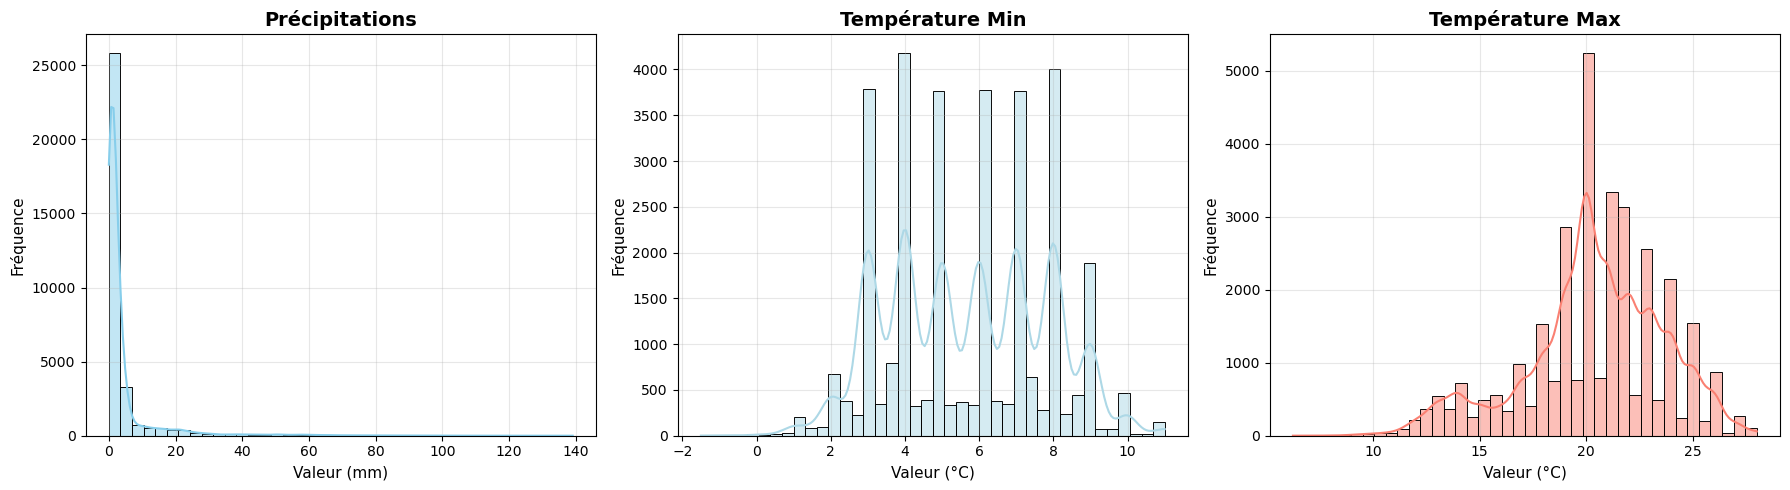

In [14]:
import numpy as np

base_dir = r"C:\Users\anfel\OneDrive\Desktop\M2\prjt\data\Climat\nv"
variables = {
    "precip_alg_tun3": {"nom": "Précipitations", "unite": "mm", "couleur": "skyblue"},
    "tmin_alg_tun3": {"nom": "Température Min", "unite": "°C", "couleur": "lightblue"},
    "tmax_alg_tun3": {"nom": "Température Max", "unite": "°C", "couleur": "salmon"}
}


fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (var_dir, var_info) in enumerate(variables.items()):
    raster_files = glob(os.path.join(base_dir, var_dir, "*.tif"))
    
    if len(raster_files) > 0:
        # Prendre le premier fichier comme exemple
        raster_path = raster_files[0]
        
        print(f"\n{var_info['nom']} - {os.path.basename(raster_path)}")
        print("-" * 60)
        
        with rasterio.open(raster_path) as raster:
            print(f"   Dimensions      : {raster.width} x {raster.height} pixels")
            print(f"   CRS             : {raster.crs}")
            print(f"   Résolution      : {raster.res[0]:.4f}°")
            
            data = raster.read(1).astype(float)
            
            # Nettoyer les données : supprimer nodata, NaN, et inf
            nodata_value = raster.nodata
            if nodata_value is not None:
                data = data[data != nodata_value]
            
            # Supprimer les NaN et les valeurs infinies
            data = data[~np.isnan(data)]
            data = data[~np.isinf(data)]
            
            # Aplatir le tableau pour l'analyse
            data_flat = data.flatten()
            
            if len(data_flat) > 0:
                print(f"   Valeur min      : {data_flat.min():.2f} {var_info['unite']}")
                print(f"   Valeur max      : {data_flat.max():.2f} {var_info['unite']}")
                print(f"   Moyenne         : {data_flat.mean():.2f} {var_info['unite']}")
                print(f"   Écart-type      : {data_flat.std():.2f} {var_info['unite']}")
                print(f"   Nombre de pixels: {len(data_flat)}")
            else:
                print(f"    Aucune donnée valide trouvée!")
                data_flat = np.array([0])  # Valeur par défaut pour éviter les erreurs
            
            # Histogramme
            if len(data_flat) > 0:
                sns.histplot(data_flat, bins=40, kde=True, 
                            color=var_info['couleur'], ax=axes[idx])
                axes[idx].set_title(f"{var_info['nom']}", fontsize=14, fontweight='bold')
                axes[idx].set_xlabel(f"Valeur ({var_info['unite']})", fontsize=11)
                axes[idx].set_ylabel("Fréquence", fontsize=11)
                axes[idx].grid(True, alpha=0.3)
            else:
                axes[idx].text(0.5, 0.5, "Pas de données valides", 
                              ha='center', va='center', fontsize=12)
                axes[idx].set_title(f"{var_info['nom']}", fontsize=14, fontweight='bold')
    else:
        print(f"\n Aucun fichier trouvé dans {var_dir}/")
        axes[idx].text(0.5, 0.5, f"Pas de données\n{var_info['nom']}", 
                      ha='center', va='center', fontsize=12)
        axes[idx].set_title(f"{var_info['nom']}", fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


In [ ]:
import xarray as xr
import pandas as pd
import os
from glob import glob
import numpy as np

# Répertoire de base contenant les dossiers de variables découpées
base_dir = r"C:\Users\anfel\OneDrive\Desktop\M2\prjt\data\Climat\nv"
variables = ["precip", "tmin", "tmax"]

# Dictionnaire pour stocker les DataArrays
data_arrays = {}

for var in variables:
    # Chemin vers les TIFs découpés
    input_dir = os.path.join(base_dir, f"{var}_alg_tun3")
    tif_files = sorted(glob(os.path.join(input_dir, "*.tif")))
    
    # Créer une liste pour stocker les DataArrays de chaque mois
    monthly_das = []
    
    # Simuler des dates (si les noms de fichiers ne les contiennent pas)
    # Dans un cas réel, il faudrait extraire les dates des noms de fichiers ou les générer
    # Ici, je suppose 12 mois pour 3 années (si 36 fichiers au total)
    if len(tif_files) == 36:
         dates = pd.to_datetime(pd.date_range(start='2022-01-01', periods=36, freq='MS'))
    else:
        # Avertissement si le nombre de fichiers est inattendu
        print(f"Attention: {len(tif_files)} fichiers trouvés pour {var}. J'utilise des dates génériques.")
        dates = pd.to_datetime(pd.date_range(start='2021-01-01', periods=len(tif_files), freq='MS'))
    
    
    # Lire tous les fichiers TIF et créer un DataArray temporel
    try:
        # Ouvrir plusieurs fichiers en même temps et créer une nouvelle dimension 'time'
        da_var = xr.open_mfdataset(tif_files, combine='nested', concat_dim='time', engine='rasterio')
        
        # Le résultat est un Dataset, extraire le DataArray
        # Je prends le premier DataArray dans le Dataset
        key_da = list(da_var.keys())[0]
        da_var = da_var[key_da]
        
        # Assigner la dimension temporelle
        da_var['time'] = dates
        
        data_arrays[var] = da_var
        print(f"DataArray pour {var} créé avec la dimension temporelle de {len(dates)} étapes.")
    except Exception as e:
        print(f"Erreur lors de la lecture des fichiers TIF pour {var} : {e}")

Attention: 12 fichiers trouvés pour precip. J'utilise des dates génériques.
DataArray pour precip créé avec la dimension temporelle de 12 étapes.
Attention: 12 fichiers trouvés pour tmin. J'utilise des dates génériques.
DataArray pour tmin créé avec la dimension temporelle de 12 étapes.
Attention: 12 fichiers trouvés pour tmax. J'utilise des dates génériques.
DataArray pour tmax créé avec la dimension temporelle de 12 étapes.


In [16]:
# S'assurer que tous les DataArrays sont dans le dictionnaire
if len(data_arrays) < 3:
    print("Impossible de continuer : il manque des DataArrays.")
else:
    # Créer un Dataset
    ds_climat = xr.Dataset(data_arrays)

    # Convertir en DataFrame pour le calcul de corrélation
    # Empiler (stack) les dimensions spatiales (y et x) en une seule dimension 'pixel'
    # et transposer (T) pour avoir les variables en colonnes et le temps/pixel en lignes
    df_climat = ds_climat.to_dataframe()
    df_climat = df_climat.unstack(level=['y', 'x']) # Remettre les pixels en colonnes

    # Transposer pour avoir les variables (precip, tmin, tmax) en colonnes
    # Les indices (time, y, x) deviennent des indices du DataFrame (multi-index)
    df_climat_flat = ds_climat.to_dataframe().dropna()

    # Le DataFrame pour la corrélation doit avoir les variables en colonnes
    # df_climat_flat contient 'precip', 'tmin', 'tmax' comme colonnes (multi-index des variables)
    
    # L'index est (time, y, x). On veut la corrélation entre les colonnes 'precip', 'tmin', 'tmax'
    
    # Nettoyer le DataFrame: Supprimer les colonnes 'band' 
    if 'band' in df_climat_flat.columns:
        df_climat_flat = df_climat_flat.drop(columns='band')
    if 'spatial_ref' in df_climat_flat.columns:
        df_climat_flat = df_climat_flat.drop(columns='spatial_ref')

    correlation_matrix = df_climat_flat.corr()

In [17]:
print("\n Matrice de Corrélation ")
print(correlation_matrix)


 Matrice de Corrélation 
          precip      tmin      tmax
precip  1.000000 -0.215508 -0.335810
tmin   -0.215508  1.000000  0.974793
tmax   -0.335810  0.974793  1.000000


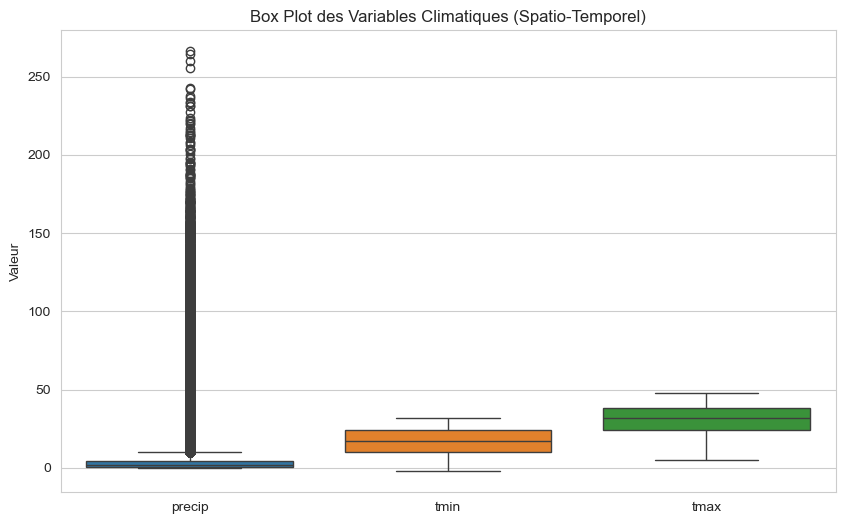

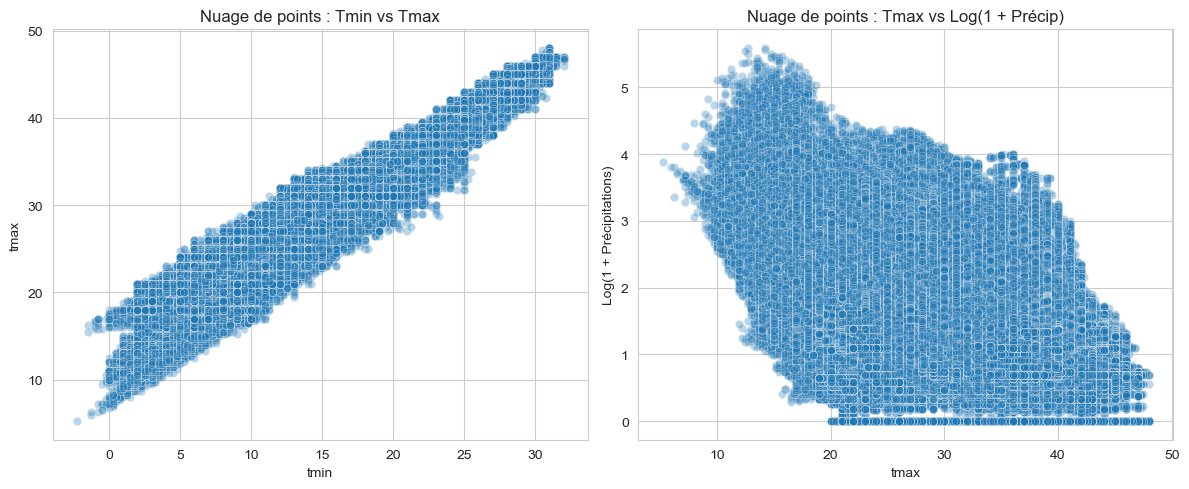

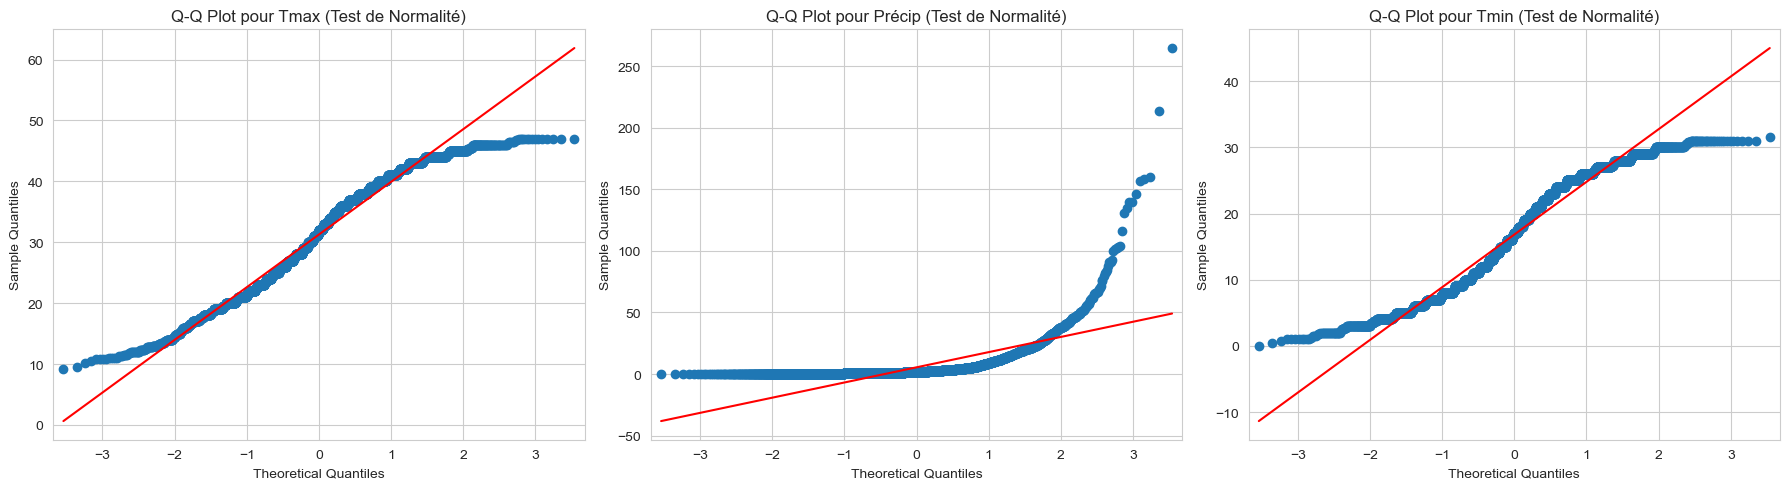

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm # Nécessaire pour les Q-Q Plots


# Configuration de base
sns.set_style("whitegrid")

# --- 1. Box Plots (Univarié) ---
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_climat_flat[['precip', 'tmin', 'tmax']])
plt.title('Box Plot des Variables Climatiques (Spatio-Temporel)')
plt.ylabel('Valeur')
plt.show()

# --- 2. Scatter Plots (Bivarié) ---
plt.figure(figsize=(12, 5))

# Scatter Plot Tmin vs Tmax
plt.subplot(1, 2, 1)
sns.scatterplot(x='tmin', y='tmax', data=df_climat_flat, alpha=0.3)
plt.title('Nuage de points : Tmin vs Tmax')

# Scatter Plot Précip vs Tmax (utiliser une échelle log pour la précipitation)
# Ajouter une petite constante pour éviter log(0)
epsilon = 0.01 
plt.subplot(1, 2, 2)
sns.scatterplot(x='tmax', y=np.log1p(df_climat_flat['precip']), data=df_climat_flat, alpha=0.3)
plt.title('Nuage de points : Tmax vs Log(1 + Précip)')
plt.ylabel('Log(1 + Précipitations)')

plt.tight_layout()
plt.show()


# --- 3. Q-Q Plots = ---

plt.figure(figsize=(18, 5))

# Q-Q Plot pour Tmax
plt.subplot(1, 3, 1)
sm.qqplot(df_climat_flat['tmax'].sample(5000), line='s', ax=plt.gca()) 
plt.title('Q-Q Plot pour Tmax (Test de Normalité)')

# Q-Q Plot pour Précip
plt.subplot(1, 3, 2)
sm.qqplot(df_climat_flat['precip'].sample(5000), line='s', ax=plt.gca())
plt.title('Q-Q Plot pour Précip (Test de Normalité)')

# Q-Q Plot pour Tmin
plt.subplot(1, 3, 3)
sm.qqplot(df_climat_flat['tmin'].sample(5000), line='s', ax=plt.gca())
plt.title('Q-Q Plot pour Tmin (Test de Normalité)')

plt.tight_layout()
plt.show()

### Outliers in precep

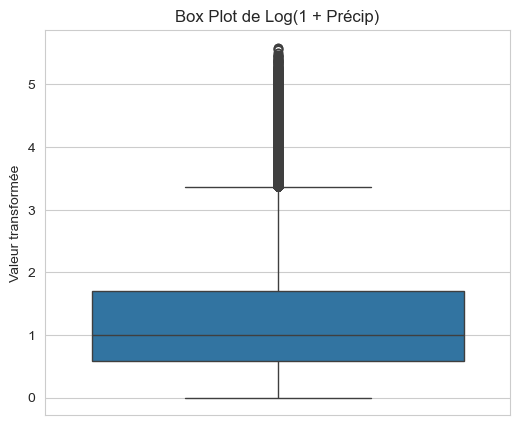

In [11]:
# Code pour la transformation et la visualisation
df_climat_flat['log_precip'] = np.log1p(df_climat_flat['precip'])

# Nouveau Box Plot avec les données transformées
plt.figure(figsize=(6, 5))
sns.boxplot(data=df_climat_flat.reset_index(), y='log_precip')
plt.title('Box Plot de Log(1 + Précip)')
plt.ylabel('Valeur transformée')
plt.show()